# Segmentation Dataset with Area of Interest Sampler
* Create Polygons for train, test and validation
* Create sampler within the polygons excluding no-pixel areas and within the boundary of the raster image if given
* Required files
  * `grid path`: path to the 10x10m squares grid
  * `fenced_area_path`: fenced area of the fields for determining the actual boundary of the fields, such that the sampler only samples inside the boundary

### Create split polygon

In [1]:
from gdl.datasets.benchmark import get_field_D_grid_split
from gdl.datasets.polygon import PolygonSplitter

grid_path='../../../field-D/grid-10m-squares/grid-10m-squares.shp'
fenced_area_path='../../../field-D/boundary-shape/boundary-shape.shp'

ps = PolygonSplitter(grid_path, fenced_area_path)

train_indices, validation_indices, test_indices = get_field_D_grid_split()

train_polygon = ps.get_polygon_by_indices(grid_indices=train_indices)
validation_polygon = ps.get_polygon_by_indices(grid_indices=validation_indices)
test_polygon = ps.get_polygon_by_indices(grid_indices=test_indices)

### Plot the polygon and raster image

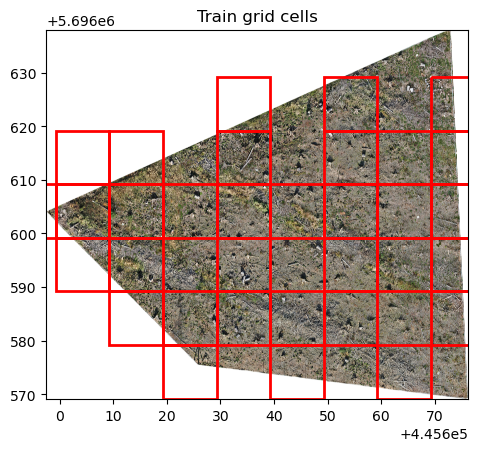

In [2]:
# plot the grid splits along with the
raster_image = '../../../field-D/d-RGB-9mm-reference.tif'
ps.plot(raster_image=raster_image,
        polygons=train_polygon,
        title="Train grid cells")

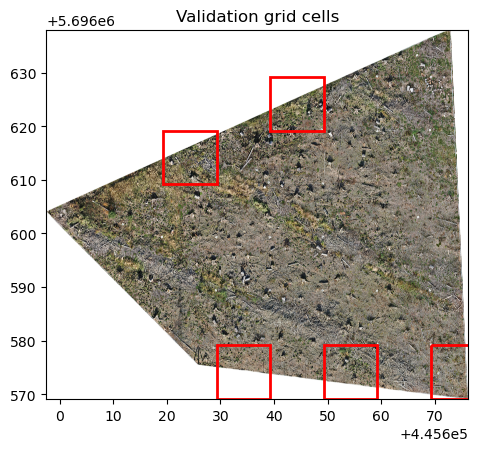

In [3]:
ps.plot(raster_image=raster_image,
        polygons=validation_polygon,
        title="Validation grid cells")

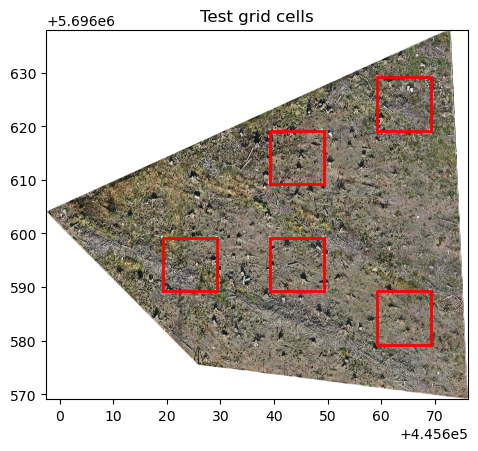

In [4]:
ps.plot(raster_image=raster_image,
        polygons=test_polygon,
        title="Test grid cells")

### Create AOI samples within the polygons

In [5]:
import torch
from gdl.datasets.geo import GarrulusSegmentationDataset
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
import kornia.augmentation as K

img_size = 224
transforms = K.AugmentationSequential(
    K.Resize(img_size),
    K.Normalize(mean=torch.tensor(0), std=torch.tensor(255)),
    data_keys=None,
)

raster_image_root_path = "../../../field-D"
mask_root_path = "../../../field-D/d-RGB-9mm-mask"
grid_path='../../../field-D/grid-10m-squares/grid-10m-squares.shp'

# create Garrulus segmentation dataset
gsd = GarrulusSegmentationDataset(raster_image_paths=raster_image_root_path, 
                                  mask_paths=mask_root_path,
                                  grid_shape_path=grid_path,
                                  transforms=transforms
                                 )

In [6]:
from gdl.samplers.single import RandomAoiGeoSampler

# create RandomAoiSampler, this method takes the samples only within the train_polygon
random_aoi_sampler = RandomAoiGeoSampler(gsd, 
                              size_lims=(50,1000),
                              polygons=train_polygon,
                              length=64,
                              outer_boundary_shape=fenced_area_path)
# create PyTorch dataloader
dataloader = DataLoader(gsd, sampler=random_aoi_sampler, collate_fn=stack_samples, batch_size=64)

image:  torch.Size([64, 3, 224, 224]) mask:  torch.Size([64, 224, 224])


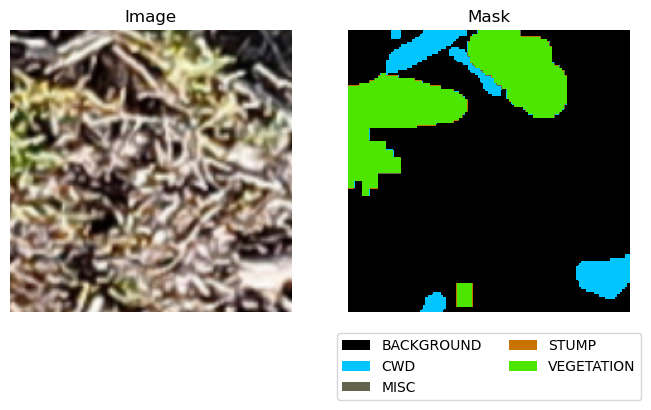

In [7]:
# Iterate through batches
for batch in dataloader:
    print("image: ", batch['image'].shape, "mask: ", batch['mask'].shape)
    sample = unbind_samples(batch)[0]
    gsd.plot(sample)
    break